# Resampling Data

I have ALMA Data set, with a angular spectral __14"__, that I need resampling to __16"__ (angular resolution spectral in SOFIA - Y. Okada - )

Resampling spectral resolution is the first step, because it is independent of the spatial axis, it reduces the error to reduce the number of channels and avoid loss of information.

**NOTE:
Each axis in the data file contains three parameters to extract: __CRVAL__ ,__CDET__ y __CRPIX__ . Do I extract all information about each channel, I applied an extraction format given by: 
$$Y = (X - X_0)m + b$$
$$AX = CRVAL + (i - CRPIX) * CDELT$$

and $i$ is the channel number, in case of frequency is between (1 - 2043)

where: 
- CRVAL: El valor de referencia del eje (frecuencia de referencia en este caso en el primer pixel).
- CDELT: El incremento en el valor de la coordenada fisica entre los pixeles consecutivos.
- CRPIX: El indice del pixel de referencia (indice donde se encuentra el valor de referencia)
- NAXIS: Numero total de canales en el eje

In [1]:
from spectral_cube import SpectralCube
import numpy as np
from astropy import units as u

import astroquery

print(astroquery.__version__)

0.4.10


In [2]:
from astroquery.splatalogue import Splatalogue

We need to match the resolution to the cube with the largest channel width, for this reason, I will use both data cubes files.
We know, by the publication, that YOKO's data, had beam to 16" and the velocity correspond to 1 km/s per channel.

(https://colab.research.google.com/github/radio-astro-tools/tutorials/blob/master/SpectralCubeReprojectExample.ipynb#scrollTo=ancient-analyst
https://spectral-cube.readthedocs.io/en/latest/smoothing.html#spectral-smoothing
https://spectral-cube.readthedocs.io/en/latest/api/spectral_cube.SpectralCube.html#spectral_cube.SpectralCube.spectral_interpolate)

In [3]:
## Open the files data cubes
file1 = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/cube_with_vel.fits'
file2 = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/FILES/N159_CII_map.fits'

cube1 = SpectralCube.read(file1) 
cube2 = SpectralCube.read(file2) 

print(cube1)
print(cube2)

from radio_beam import Beam

header1 = cube1.header
header2 = cube2.header

print(header2)
#beam1 = Beam.from_fits_header(header1)
#beam2 = Beam.from_fits_header(header2)   #Dont have the beam in the header  

#print(beam1)  #Beam values are utilized in spatial resampling
#print(beam2)

SpectralCube with shape=(2043, 128, 120) and unit=Jy / beam:
 n_x:    120  type_x: RA---SIN  unit_x: deg    range:    84.794668 deg:   85.014927 deg
 n_y:    128  type_y: DEC--SIN  unit_y: deg    range:   -69.807597 deg:  -69.726457 deg
 n_s:   2043  type_s: VRAD      unit_s: km / s  range:     -129.445 km / s:     599.071 km / s
SpectralCube with shape=(300, 59, 58):
 n_x:     58  type_x: RA---TAN  unit_x: deg    range:    84.847002 deg:   85.091617 deg
 n_y:     59  type_y: DEC--TAN  unit_y: deg    range:   -69.805244 deg:  -69.719243 deg
 n_s:    300  type_s: VELO      unit_s: m / s  range:     -149.000 m / s:     150.000 m / s
SIMPLE  =                    T / Written by IDL:  Tue Mar 28 14:54:01 2017      BITPIX  =                  -64 / Number of bits per data pixel                  NAXIS   =                    3                                                  NAXIS1  =                   58                                                  NAXIS2  =                   59           

In [4]:
#Due that YOKO have the VEL in m/s, change the units to km/s

#The rest Freq of [CII] is 1900.5369 GHz
RESTFRQ = 1.9005369e12 * u.Hz
cube2_km = cube2.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=RESTFRQ)
print(cube2_km)

SpectralCube with shape=(300, 59, 58):
 n_x:     58  type_x: RA---TAN  unit_x: deg    range:    84.847002 deg:   85.091617 deg
 n_y:     59  type_y: DEC--TAN  unit_y: deg    range:   -69.805244 deg:  -69.719243 deg
 n_s:    300  type_s: VELO      unit_s: km / s  range:       -0.149 km / s:       0.150 km / s


C:\Users\macka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\spectral_cube\spectral_cube.py:436: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


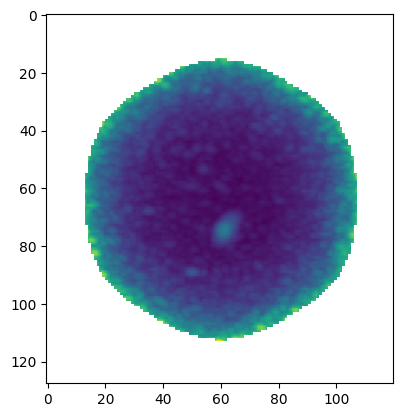

In [5]:
### Explore the structure in the cubes
cube1.max(axis=0).quicklook()

C:\Users\macka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\spectral_cube\spectral_cube.py:436: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


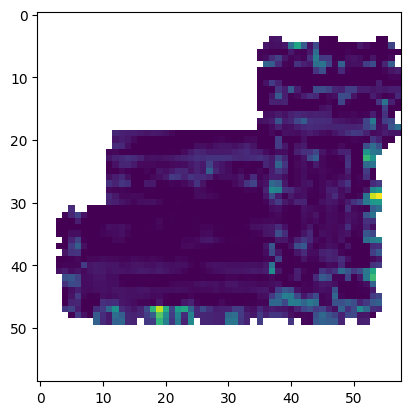

In [6]:
cube2.max(axis=0).quicklook()

It is necessary that both cubes have the same spectral grid, i.e that share the same velocity or frequency values on the spectral axis.
Due that, both cubes dont have the same range, is necesarry  reduce the our datas at the same spectral range of YOKO's datas.

For convenience, since the yoko data have the spectral axis in (m/s) and are in a range that is not in accordance with that indicated in the publication, use a cut-off value of vrad = 198 to 305

In [7]:
vel_res1 = np.diff(cube1.spectral_axis)[0]
vel_res2 = np.diff(cube2.spectral_axis)[0]
vel_res1, vel_res2

(<Quantity -0.3567656 km / s>, <Quantity 1. m / s>)

In [8]:
cube2.spectral_axis.min(), cube2.spectral_axis.max()

(<Quantity -149. m / s>, <Quantity 150. m / s>)

In [ ]:
#cube1_cut = cube1.spectral_slab(198.0 * u.km / u.s - vel_res1 , 305.0 * u.km / u.s) #agree (- vel_res1), for ensures that cube covers the entire speed range
cube1_cut = cube1.spectral_slab(-129.0 * u.km / u.s - vel_res1 , 600.0 * u.km / u.s) 
cube1_cut

SpectralCube with shape=(2043, 128, 120) and unit=Jy / beam:
 n_x:    120  type_x: RA---SIN  unit_x: deg    range:    84.794668 deg:   85.014927 deg
 n_y:    128  type_y: DEC--SIN  unit_y: deg    range:   -69.807597 deg:  -69.726457 deg
 n_s:   2043  type_s: VRAD      unit_s: km / s  range:     -129.445 km / s:     599.071 km / s

We need to first smooth our datacube to the broader channel width before doing the spatial reprojection. I can smooth the cube with a Gaussian Kernel that has a width of: $$ FWHM_{KERNEL} = \sqrt{FWHM_{fin}^2 - FWHM_{orig}^2} $$
where: 
- $FWHM_{fin} = 1$
- $FWHM_{orig} = 0.3567656$



In [18]:
from astropy.convolution import Gaussian1DKernel
FWHM_orig = 0.3567656  #FWHM of the original cube
FWHM_fin = 1  #FWHM of the final cube

stdv = (FWHM_fin**2 - FWHM_orig**2)**0.5 
print(stdv)

0.9341939341788941


We know that to transform to FWHM to sigma, we have a conversion factor given by: 
$$ FWHM = \sigma \sqrt{8ln2} $$


In [19]:
#reference unit used to calculate the width of the convolution kernel
pixel_scale = np.abs(np.diff(cube1.spectral_axis)[0]) *u.s / u.km
print(pixel_scale)

0.3567656013855185


In [20]:
factor = (8*np.log(2))**0.5

kernel = Gaussian1DKernel(stddev=stdv / 0.356766 / factor)
print(kernel)

In [21]:
smoothcube = cube1.spectral_smooth(kernel)
print(smoothcube)

SpectralCube with shape=(2043, 128, 120) and unit=Jy / beam:
 n_x:    120  type_x: RA---SIN  unit_x: deg    range:    84.794668 deg:   85.014927 deg
 n_y:    128  type_y: DEC--SIN  unit_y: deg    range:   -69.807597 deg:  -69.726457 deg
 n_s:   2043  type_s: VRAD      unit_s: km / s  range:     -129.445 km / s:     599.071 km / s


Now that we've done spectral smoothing, we can resample the spectral axis. For this, I use  the function .spectral_interpolate()

In [ ]:
#newspectral_cube = np.arange(85.0, 385.0, 1.0) * u.km / u.s #same quantity of channel as the cube2
newspectral_cube = np.arange(-129.0, 600.0, 1.0) * u.km / u.s 
cube_resampled = smoothcube.spectral_interpolate(newspectral_cube, suppress_smooth_warning=True)
print(cube_resampled)

Spectral Interpolate:   0%|          | 0/15360 [00:00<?, ?it/s]

SpectralCube with shape=(729, 128, 120) and unit=Jy / beam:
 n_x:    120  type_x: RA---SIN  unit_x: deg    range:    84.794668 deg:   85.014927 deg
 n_y:    128  type_y: DEC--SIN  unit_y: deg    range:   -69.807597 deg:  -69.726457 deg
 n_s:    729  type_s: VRAD      unit_s: km / s  range:     -129.000 km / s:     599.000 km / s


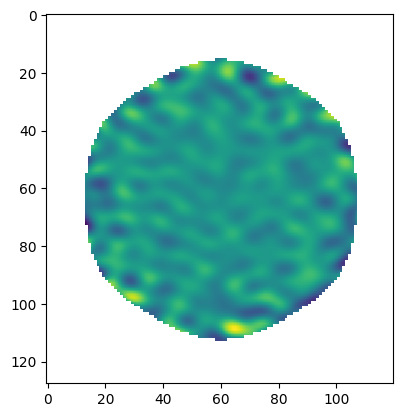

In [ ]:
cube_resampled[150, :, :].quicklook() #check the cube

In [ ]:
#save the cube
cube_resampled.write("C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/cube_Spect_resampl_ALL.fits", overwrite=True)
#cube_resampled.write("C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/cube_Spect_resampl.fits", overwrite=True)